## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [19]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [20]:
train, test = keras.datasets.cifar10.load_data()

In [21]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [22]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [23]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Code Here
    建立你的神經網路
    """
    # input
    input_layer = keras.layers.Input(input_shape)
    
    # hidden
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    # output
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [24]:

LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024

In [25]:

# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
optimizer_set2 = ['SGD', 'ADAM', 'RMSPROP']
"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0, 0.25, 0.5, 0.8]
redice_lr_patient = [5, 20]

In [26]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience = reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 3s 65us/step - loss: 3.0658 - accuracy: 0.0908 - val_loss: 2.9149 - val_accuracy: 0.0864
Epoch 11/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.0653 - accuracy: 0.0901 - val_loss: 2.9556 - val_accuracy: 0.0862
Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0652 - accuracy: 0.0902 - val_loss: 2.9888 - val_accuracy: 0.0861
Epoch 13/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.0645 - accuracy: 0.0908 - val_loss: 3.0151 - val_accuracy: 0.0860
Epoch 14/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.0660 - accuracy: 0.0906 - val_loss: 3.0349 - val_accuracy: 0.0866
Epoch 15/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.0650 - accuracy: 0.0895 - val_loss: 3.0496 - val_accuracy: 0.0871
Epoch 16/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0653 - accuracy: 0.0902 - val_loss: 3.0599

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 71us/step - loss: 3.1334 - accuracy: 0.0891 - val_loss: 2.3584 - val_accuracy: 0.1045
Epoch 2/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.1347 - accuracy: 0.0901 - val_loss: 2.4068 - val_accuracy: 0.1040
Epoch 3/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.1352 - accuracy: 0.0894 - val_loss: 2.4802 - val_accuracy: 0.1069
Epoch 4/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.1354 - accuracy: 0.0894 - val_loss: 2.5569 - val_accuracy: 0.1036
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 3.1343 - accuracy: 0.0887 - val_loss: 2.6328 - val_accuracy: 0.1012
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.1341 - accuracy: 0.0899 - val_loss: 2.7071 - val_accuracy: 0.0949
Epoch 7/25
50000/50000 [==============================] - 3s 65us/st

Epoch 21/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9518 - accuracy: 0.1124 - val_loss: 2.9519 - val_accuracy: 0.1095
Epoch 22/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.9524 - accuracy: 0.1130 - val_loss: 2.9527 - val_accuracy: 0.1096
Epoch 23/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9528 - accuracy: 0.1127 - val_loss: 2.9532 - val_accuracy: 0.1096
Epoch 24/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9529 - accuracy: 0.1126 - val_loss: 2.9532 - val_accuracy: 0.1096
Epoch 25/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.9521 - accuracy: 0.1132 - val_loss: 2.9532 - val_accuracy: 0.1096
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 20
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.0428 - accuracy: 0.1000 - val_loss: 2.6037 - val_accuracy: 0.1041
Epoch 7/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0421 - accuracy: 0.0999 - val_loss: 2.6767 - val_accuracy: 0.1040
Epoch 8/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.0417 - accuracy: 0.0988 - val_loss: 2.7455 - val_accuracy: 0.1045
Epoch 9/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0417 - accuracy: 0.0995 - val_loss: 2.8072 - val_accuracy: 0.1052
Epoch 10/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0401 - accuracy: 0.0996 - val_loss: 2.8601 - val_accuracy: 0.1049
Epoch 11/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.0422 - accuracy: 0.0995 - val_loss: 2.9042 - val_accuracy: 0.1052
Epoch 12/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0415 - accuracy: 0.0996 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.7615 - accuracy: 0.3874 - val_loss: 2.3335 - val_accuracy: 0.2348
Epoch 2/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4893 - accuracy: 0.4750 - val_loss: 1.8069 - val_accuracy: 0.3660
Epoch 3/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.3899 - accuracy: 0.5088 - val_loss: 2.0704 - val_accuracy: 0.3016
Epoch 4/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.3109 - accuracy: 0.5368 - val_loss: 1.8073 - val_accuracy: 0.3681
Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.2445 - accuracy: 0.5642 - val_loss: 1.8381 - val_accuracy: 0.3460
Epoch 6/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.1874 - accuracy: 0.5828 - val_loss: 1.6325 - val_accuracy: 0.4284
Epoch 7/25
50000/50000 [==============================] - 3s 66us/st

50000/50000 [==============================] - 3s 67us/step - loss: 3.0123 - accuracy: 0.0969 - val_loss: 3.0012 - val_accuracy: 0.1000
Epoch 21/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.0116 - accuracy: 0.0985 - val_loss: 3.0026 - val_accuracy: 0.1000
Epoch 22/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.0106 - accuracy: 0.0978 - val_loss: 3.0035 - val_accuracy: 0.1000
Epoch 23/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.0115 - accuracy: 0.0977 - val_loss: 3.0039 - val_accuracy: 0.1000
Epoch 24/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.0109 - accuracy: 0.0976 - val_loss: 3.0041 - val_accuracy: 0.1001
Epoch 25/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.0092 - accuracy: 0.0982 - val_loss: 3.0044 - val_accuracy: 0.1001
Numbers of exp: 10, reduce_factor: 0.25, reduce_patient: 5
Model: "model_11"
_______________________________________________

Epoch 5/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1143 - accuracy: 0.0973 - val_loss: 2.6682 - val_accuracy: 0.0892
Epoch 6/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1149 - accuracy: 0.0975 - val_loss: 2.7413 - val_accuracy: 0.0896
Epoch 7/25
50000/50000 [==============================] - 3s 69us/step - loss: 3.1142 - accuracy: 0.0968 - val_loss: 2.8070 - val_accuracy: 0.0894
Epoch 8/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1149 - accuracy: 0.0974 - val_loss: 2.8656 - val_accuracy: 0.0924
Epoch 9/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1150 - accuracy: 0.0962 - val_loss: 2.9173 - val_accuracy: 0.0917
Epoch 10/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1151 - accuracy: 0.0970 - val_loss: 2.9619 - val_accuracy: 0.0940
Epoch 11/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1136 - accuracy: 0.0961 - val_loss:

50000/50000 [==============================] - 3s 68us/step - loss: 3.0243 - accuracy: 0.0939 - val_loss: 3.0263 - val_accuracy: 0.0962
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 20
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_40 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_41 (Batc (None, 256)               1024      
____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.9848 - accuracy: 0.0971 - val_loss: 2.8149 - val_accuracy: 0.1005
Epoch 11/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9852 - accuracy: 0.0970 - val_loss: 2.8548 - val_accuracy: 0.0993
Epoch 12/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9854 - accuracy: 0.0972 - val_loss: 2.8868 - val_accuracy: 0.0996
Epoch 13/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9861 - accuracy: 0.0965 - val_loss: 2.9124 - val_accuracy: 0.0998
Epoch 14/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9852 - accuracy: 0.0963 - val_loss: 2.9317 - val_accuracy: 0.1000
Epoch 15/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9857 - accuracy: 0.0964 - val_loss: 2.9456 - val_accuracy: 0.0991
Epoch 16/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9858 - accuracy: 0.0974 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.8062 - accuracy: 0.3746 - val_loss: 2.7962 - val_accuracy: 0.1857
Epoch 2/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5398 - accuracy: 0.4539 - val_loss: 1.9002 - val_accuracy: 0.3201
Epoch 3/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.4272 - accuracy: 0.4957 - val_loss: 2.0971 - val_accuracy: 0.3037
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.3537 - accuracy: 0.5189 - val_loss: 1.8412 - val_accuracy: 0.3616
Epoch 5/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.2920 - accuracy: 0.5431 - val_loss: 2.0644 - val_accuracy: 0.3420
Epoch 6/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.2490 - accuracy: 0.5610 - val_loss: 2.1574 - val_accuracy: 0.3095
Epoch 7/25
50000/50000 [==============================] - 3s 65us/st

50000/50000 [==============================] - 3s 66us/step - loss: 3.1505 - accuracy: 0.0847 - val_loss: 3.1427 - val_accuracy: 0.0854
Epoch 21/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.1486 - accuracy: 0.0843 - val_loss: 3.1440 - val_accuracy: 0.0854
Epoch 22/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.1493 - accuracy: 0.0839 - val_loss: 3.1447 - val_accuracy: 0.0853
Epoch 23/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.1488 - accuracy: 0.0846 - val_loss: 3.1454 - val_accuracy: 0.0853
Epoch 24/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1487 - accuracy: 0.0848 - val_loss: 3.1457 - val_accuracy: 0.0853
Epoch 25/25
50000/50000 [==============================] - 3s 68us/step - loss: 3.1497 - accuracy: 0.0848 - val_loss: 3.1458 - val_accuracy: 0.0854
Numbers of exp: 18, reduce_factor: 0.25, reduce_patient: 5
Model: "model_19"
_______________________________________________

Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.9048 - accuracy: 0.1153 - val_loss: 2.5374 - val_accuracy: 0.1090
Epoch 6/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.9037 - accuracy: 0.1163 - val_loss: 2.5902 - val_accuracy: 0.1099
Epoch 7/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.9046 - accuracy: 0.1157 - val_loss: 2.6357 - val_accuracy: 0.1110
Epoch 8/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.9043 - accuracy: 0.1156 - val_loss: 2.6772 - val_accuracy: 0.1121
Epoch 9/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.9049 - accuracy: 0.1160 - val_loss: 2.7154 - val_accuracy: 0.1136
Epoch 10/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.9045 - accuracy: 0.1143 - val_loss: 2.7501 - val_accuracy: 0.1159
Epoch 11/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.9048 - accuracy: 0.1150 - val_loss:

50000/50000 [==============================] - 3s 67us/step - loss: 2.9584 - accuracy: 0.1117 - val_loss: 2.9528 - val_accuracy: 0.1095
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 20
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_64 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_65 (Batc (None, 256)               1024      
____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9465 - accuracy: 0.1192 - val_loss: 2.7879 - val_accuracy: 0.1168
Epoch 11/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9461 - accuracy: 0.1184 - val_loss: 2.8252 - val_accuracy: 0.1164
Epoch 12/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9464 - accuracy: 0.1194 - val_loss: 2.8565 - val_accuracy: 0.1177
Epoch 13/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9452 - accuracy: 0.1197 - val_loss: 2.8818 - val_accuracy: 0.1177
Epoch 14/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9460 - accuracy: 0.1197 - val_loss: 2.9015 - val_accuracy: 0.1183
Epoch 15/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9464 - accuracy: 0.1191 - val_loss: 2.9161 - val_accuracy: 0.1180
Epoch 16/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.9450 - accuracy: 0.1191 - val_

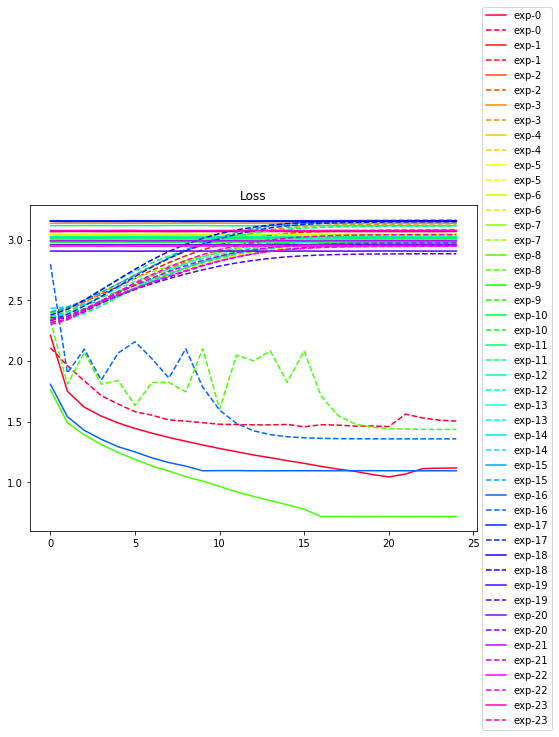

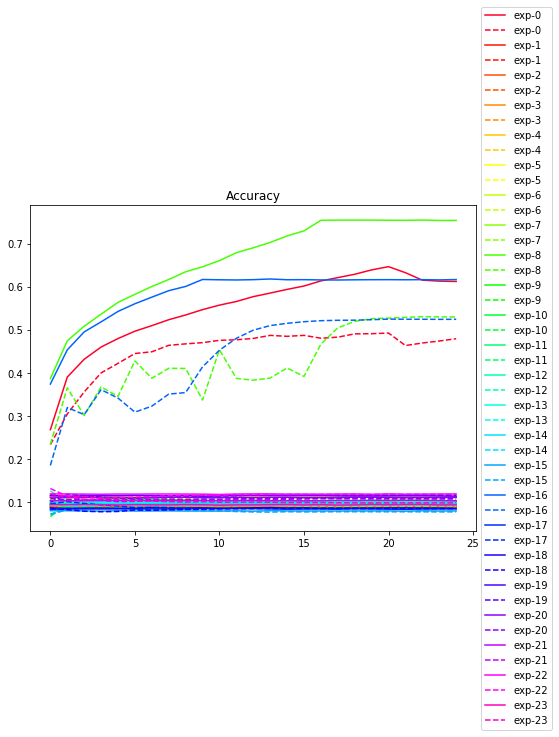

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()